# Project: **Car Behavioral Cloning using Keras** 
**In this project, I used a deep neural network (built with [Keras](https://keras.io/)) to clone car driving behavior.**

**The dataset used to train the network is generated from [Udacity's Self-Driving Car Simulator](https://github.com/udacity/self-driving-car-sim), and it consists of images taken from three different camera angles (Center - Left - Right), in addition to the steering angle, throttle, brake, and speed during each frame.**

**The network is based on NVIDIA's paper [End to End Learning for Self-Driving Cars](https://arxiv.org/pdf/1604.07316v1.pdf), which has been proven to work in this problem domain.**

## Pipeline architecture:
- **Data Loading.**
- **Data Augmentation.**
- **Data Preprocessing.**
- **Model Architecture.**
- **Model Training.**

I'll explain each step in details below.

#### Environement:
-  Ubuntu 16.04
-  Anaconda 5.0.1
-  Python 3.6.2
-  Keras 1.2.1
-  TensorFlow 0.12.1 (GPU: NVIDIA GTX 1070)

In [1]:
# Importing Python libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import csv
import cv2
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

Using TensorFlow backend.


---
## Step 1: Data Loading

Download the dataset from [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip).
This dataset contains more than 8,000 frame images taken from the 3 cameras (3 images for each frame), in addition to a `csv` file with the steering angle, throttle, brake, and speed during each frame.

In [3]:
data_dir = './data/'
labels_file = './data/driving_log.csv'

In [4]:
def load_data(labels_file, test_size):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            labels_file: The labels CSV file.
            test_size: The size of the testing set.
    """
    labels = pd.read_csv(labels_file)
    X = labels[['center', 'left', 'right']].values
    y = labels['steering'].values
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=0)

    return X_train, X_valid, y_train, y_valid

In [5]:
def load_image(data_dir, image_file):
    """
    Load RGB image.
        Parameters:
            data_dir: The directory where the images are.
            image_file: The image file name.
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

In [17]:
data = load_data(labels_file, 0.2)

In [80]:
def list_images(data, labels):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            dataset: An np.array compatible with plt.imshow.
            labels: A string to be used as a label for each image.
    """
    plt.figure(figsize=(15, 16))
    indx = 0
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(load_image(data_dir, str(data[indx])))
        plt.xlabel("Steering angle: {:.5f}".format(labels[indx]))
        plt.xticks([])
        plt.yticks([])
        indx += 1
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

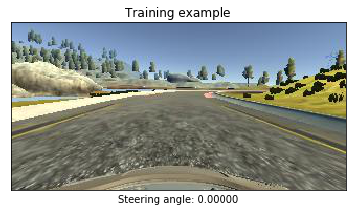

In [84]:
plt.imshow(load_image(data_dir, str(data[0][0][0])))
plt.xlabel("Steering angle: {:.5f}".format(data[2][0]))
plt.title("Training example")
plt.xticks([])
plt.yticks([])
plt.show()

---
## Step 1: Data Preprocessing

### Preprocessing steps:
-  Cropping the image to cut off the sky scene and the car front.
-  Resizing the image to (66 * 200), the image size that the model expects.
-  Converting the image to the YUV color space.

In [6]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

In [7]:
def preprocess(img):
    """
    Preprocessing (Crop - Resize - Convert to YUV) the input image.
        Parameters:
            img: The input image to be preprocessed.
    """
    # Cropping the image
    img = img[60:-25, :, :]
    # Resizing the image
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    # Converting the image to YUV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img

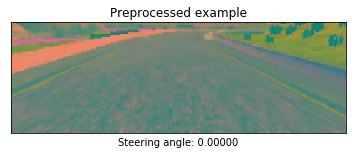

In [86]:
plt.imshow(preprocess(load_image(data_dir, str(data[0][0][0]))))
plt.xlabel("Steering angle: {:.5f}".format(data[2][0]))
plt.title("Preprocessed example")
plt.xticks([])
plt.yticks([])
plt.show()

---
## Step 2: Data Augmentation

### Augmentation steps:
-  Adjusting the steering angle of random images.
-  Flipping random images horizontaly, with steering angle adjustment.
-  Shifting (Translating) random images, with steering angle adjustment.
-  Adding shadows to random images.
-  Altering the brightness of random images.

In [118]:
def random_adjust(data_dir, center, left, right, steering_angle):
    """
    Adjusting the steering angle of random images.
        Parameters:
            data_dir: The directory where the images are.
            center: Center image.
            left: Left image.
            right: Right image
            steering_angle: The steering angle of the input frame.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle

In [89]:
def random_flip(image, steering_angle):
    """
    Randomly flipping the input image horizontaly, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

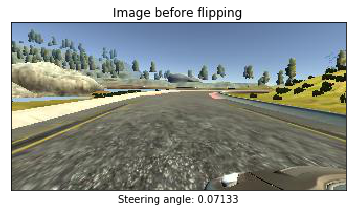

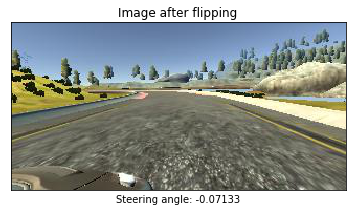

In [148]:
img = load_image(data_dir, str(data[0][0][1]))

plt.imshow(img)
plt.xlabel("Steering angle: {:.5f}".format(data[2][1]))
plt.title("Image before flipping")
plt.xticks([])
plt.yticks([])
plt.show()

img = random_flip(img, data[2][1])
plt.imshow(img[0])
plt.xlabel("Steering angle: {:.5f}".format(img[1]))
plt.title("Image after flipping")
plt.xticks([])
plt.yticks([])
plt.show()

In [150]:
def random_shift(image, steering_angle, range_x, range_y):
    """
    Shifting (Translating) the input images, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
            range_x: Horizontal translation range.
            range_y: Vertival translation range.
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

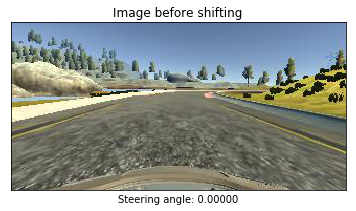

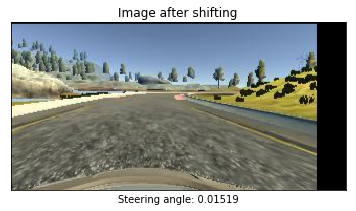

In [158]:
img = load_image(data_dir, str(data[0][0][0]))

plt.imshow(img)
plt.xlabel("Steering angle: {:.5f}".format(data[2][0]))
plt.title("Image before shifting")
plt.xticks([])
plt.yticks([])
plt.show()

img = random_shift(img, data[2][1], 100, 10)
plt.imshow(img[0])
plt.xlabel("Steering angle: {:.5f}".format(img[1]))
plt.title("Image after shifting")
plt.xticks([])
plt.yticks([])
plt.show()

In [159]:
def random_shadow(image):
    """
    Adding shadow to the input image.
        Parameters:
            image: The input image.
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

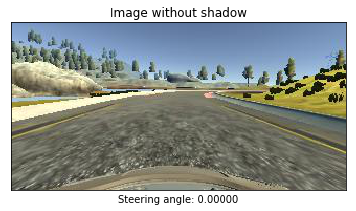

C:\Users\Mohamed.Ameen\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 160 but corresponding boolean dimension is 66


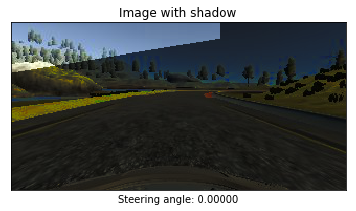

In [168]:
img = load_image(data_dir, str(data[0][0][0]))

plt.imshow(img)
plt.xlabel("Steering angle: {:.5f}".format(data[2][0]))
plt.title("Image without shadow")
plt.xticks([])
plt.yticks([])
plt.show()

img = random_shadow(img)
plt.imshow(img)
plt.xlabel("Steering angle: {:.5f}".format(data[2][0]))
plt.title("Image with shadow")
plt.xticks([])
plt.yticks([])
plt.show()

In [203]:
def random_brightness(image):
    """
    Altering the brightness of the input image.
        Parameters:
            image: The input image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

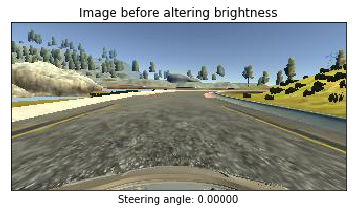

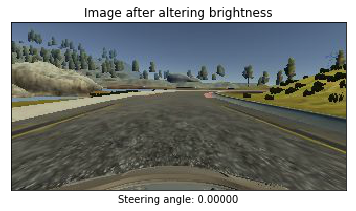

In [205]:
img = load_image(data_dir, str(data[0][0][0]))

plt.imshow(img)
plt.xlabel("Steering angle: {:.5f}".format(data[2][0]))
plt.title("Image before altering brightness")
plt.xticks([])
plt.yticks([])
plt.show()

img = random_brightness(img)
plt.imshow(img)
plt.xlabel("Steering angle: {:.5f}".format(data[2][0]))
plt.title("Image after altering brightness")
plt.xticks([])
plt.yticks([])
plt.show()

In [206]:
def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust the associated steering angle.
        Parameters:
            data_dir: The directory where the images are.
            center: Center image.
            left: Left image.
            right: Right image
            steering_angle: The steering angle related to the input frame.
            range_x (Default = 100): Horizontal translation range.
            range_y (Default = 10): Vertival translation range.
    """
    image, steering_angle = random_adjust(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_shift(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

---
## Step 3: Model Architecture

In this step, we will design and implement a deep learning model that can clone the vehicle's behavior.
We'll use a convolutional neural network (CNN) to map raw pixels from a single front-facing camera directly to steering commands.

We'll use the ConvNet from NVIDIA's paper [End to End Learning for Self-Driving Cars](https://arxiv.org/pdf/1604.07316v1.pdf), which has been proven to work in this problem domain.

<figure>
 <img src="Training_the_neural_network.png" width="1654" alt="Combined Image" />
 <figcaption>
 <p></p>
 </figcaption>
</figure>

According to the paper: *"We train the weights of our network to minimize the mean squared error between the steering command output by the network and the command of either the human driver, or the adjusted steering command for off-center and rotated images. Our network architecture is shown in Figure 4. The network consists of 9 layers, including a normalization layer, 5 convolutional layers and 3 fully connected layers. The input image is split into YUV planes and passed to the network.
The first layer of the network performs image normalization. The normalizer is hard-coded and is not adjusted in the learning process. Performing normalization in the network allows the normalization scheme to be altered with the network architecture and to be accelerated via GPU processing.
The convolutional layers were designed to perform feature extraction and were chosen empirically through a series of experiments that varied layer configurations. We use strided convolutions in the first three convolutional layers with a 2×2 stride and a 5×5 kernel and a non-strided convolution with a 3×3 kernel size in the last two convolutional layers.
We follow the five convolutional layers with three fully connected layers leading to an output control value which is the inverse turning radius. The fully connected layers are designed to function as a controller for steering, but we note that by training the system end-to-end, it is not possible to make a clean break between which parts of the network function primarily as feature extractor and which serve as controller."*

<figure>
 <img src="NVIDIA_model.png" width="624" alt="Combined Image" />
 <figcaption>
 <p></p>
 </figcaption>
</figure>

In [210]:
def NVIDIA_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

---
## Step 3: Model Training

In [227]:
batch_size = 40
samples_per_epoch = 20000
nb_epoch = 10

In [213]:
def batcher(data_dir, image_paths, steering_angles, batch_size, training_flag):
    """
    Generate a training image given image paths and the associated steering angles
        Parameters:
            data_dir: The directory where the images are.
            image_paths: Paths to the input images.
            steering_angle: The steering angle related to the input frame.
            batch_size: The batch size used to train the model.
            training_flag: A flag to determine whether we're in training or validation mode.
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # Argumentation
            if training_flag and np.random.rand() < 0.6:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center) 
            # Add the image and steering angle to the batch
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

In [225]:
def train_model(model, X_train, X_valid, y_train, y_valid):
    checkpoint = ModelCheckpoint('model-{val_loss:03f}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
    model.compile(loss='mse', optimizer=Adam(lr=1.0e-4))
    model.fit_generator(batcher(data_dir, X_train, y_train, batch_size, True),
                        samples_per_epoch,
                        nb_epoch,
                        max_q_size=1,
                        validation_data=batcher(data_dir, X_valid, y_valid, batch_size, False),
                        nb_val_samples=len(X_valid),
                        callbacks=[checkpoint],
                        verbose=1)

In [228]:
model = NVIDIA_model()
train_model(model, *data)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_9 (Lambda)                (None, 66, 200, 3)    0           lambda_input_9[0][0]             
____________________________________________________________________________________________________
convolution2d_41 (Convolution2D) (None, 31, 98, 24)    1824        lambda_9[0][0]                   
____________________________________________________________________________________________________
convolution2d_42 (Convolution2D) (None, 14, 47, 36)    21636       convolution2d_41[0][0]           
____________________________________________________________________________________________________
convolution2d_43 (Convolution2D) (None, 5, 22, 48)     43248       convolution2d_42[0][0]           
___________________________________________________________________________________________

C:\Users\Mohamed.Ameen\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 160 but corresponding boolean dimension is 66


20000/20000 [==============================] - 450s - loss: 0.0262 - val_loss: 0.0092
Epoch 2/10
20000/20000 [==============================] - 436s - loss: 0.0212 - val_loss: 0.0103
Epoch 3/10
20000/20000 [==============================] - 426s - loss: 0.0180 - val_loss: 0.0084
Epoch 4/10
20000/20000 [==============================] - 428s - loss: 0.0168 - val_loss: 0.0105
Epoch 5/10
20000/20000 [==============================] - 424s - loss: 0.0159 - val_loss: 0.0101
Epoch 6/10
20000/20000 [==============================] - 427s - loss: 0.0163 - val_loss: 0.0101
Epoch 7/10
20000/20000 [==============================] - 426s - loss: 0.0153 - val_loss: 0.0089
Epoch 8/10
20000/20000 [==============================] - 430s - loss: 0.0149 - val_loss: 0.0084
Epoch 9/10
20000/20000 [==============================] - 419s - loss: 0.0148 - val_loss: 0.0087
Epoch 10/10
20000/20000 [==============================] - 419s - loss: 0.0142 - val_loss: 0.0092
